In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import h5py
from math import pi
import pickle

from analysis.config import h5_path_dict, pickle_dir
from analysis.ExpData import ExpData
from analysis.utils import in_ellipse, get_max_consecutive

In [2]:
with open(pickle_dir / 'check_params.p', 'rb') as f:
    params = pickle.load(f)
body_centers = params['body_centers']
body_semiaxes = params['body_semiaxes']
head_centers = params['head_centers']
head_semiaxes = params['head_semiaxes']

## Get thresholds for each Check ROI

In [41]:
# Collect Head/Body in ROI values
all_head_in_roi = [[] for _ in range(16)]
all_body_in_roi = [[] for _ in range(16)]
all_both_in_roi = []
all_both_in_roi_sites = []
for key in h5_path_dict.keys():
    if "RBY" in key: continue
    for fil in range(len(h5_path_dict[key])):
        fil_string = h5_path_dict[key][fil].as_posix()
        f = h5py.File(fil_string, 'r')
        exp_data = ExpData(f)
        for event_idx, event_poke in enumerate(exp_data.event_pokes):
            event_site = exp_data.event_sites[event_idx]
            event_start = event_poke - 20*2
            event_end = event_poke + 20*2
            head_in_roi = in_ellipse(
                exp_data.x_head[event_start:event_end],
                exp_data.y_head[event_start:event_end],
                head_centers[event_site - 1], head_semiaxes[event_site - 1]
                )
            body_in_roi = in_ellipse(
                exp_data.x[event_start:event_end],
                exp_data.y[event_start:event_end],
                body_centers[event_site - 1], body_semiaxes[event_site - 1]
                )
            both_in_roi = np.logical_and(head_in_roi, body_in_roi)
            all_head_in_roi[event_site-1].append(
                get_max_consecutive(head_in_roi)
                )
            all_body_in_roi[event_site-1].append(
                get_max_consecutive(body_in_roi)
                )
            all_both_in_roi.append(get_max_consecutive(both_in_roi))
            all_both_in_roi_sites.append(event_site)
all_both_in_roi = np.array(all_both_in_roi)
all_both_in_roi_sites = np.array(all_both_in_roi_sites)

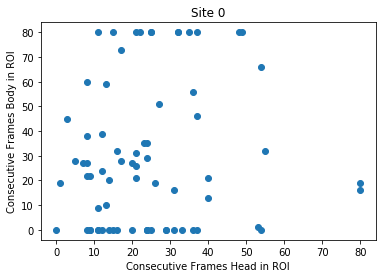

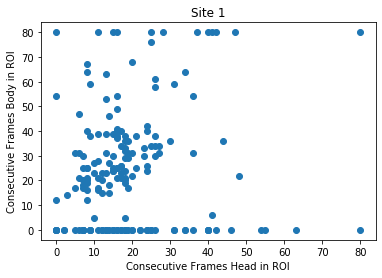

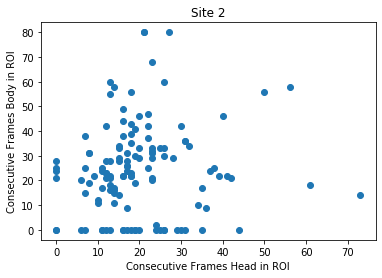

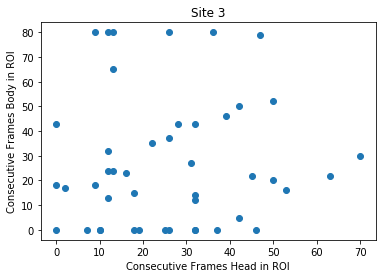

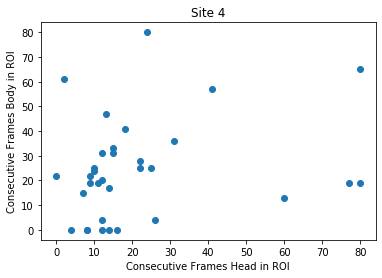

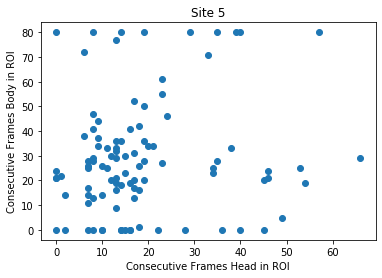

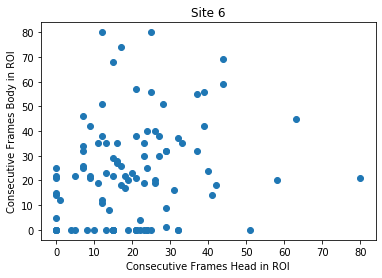

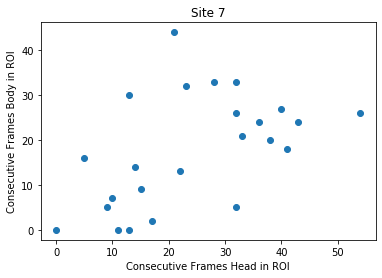

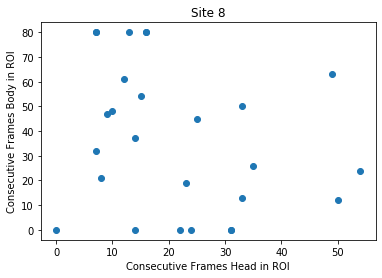

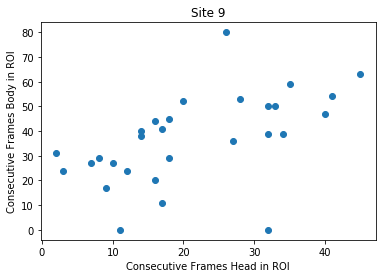

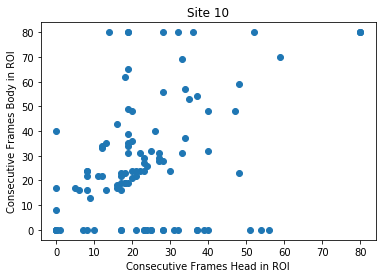

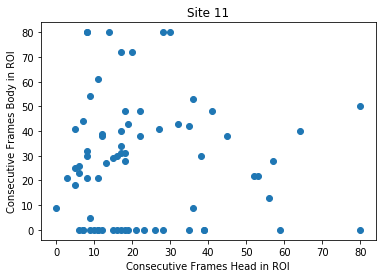

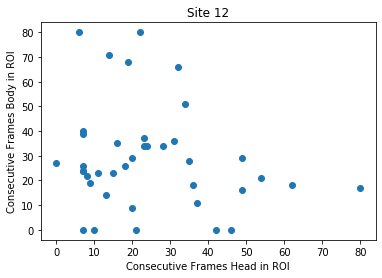

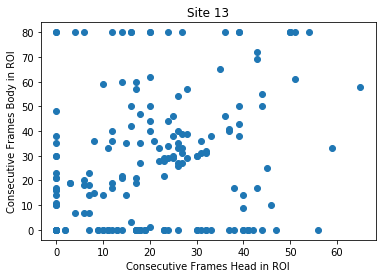

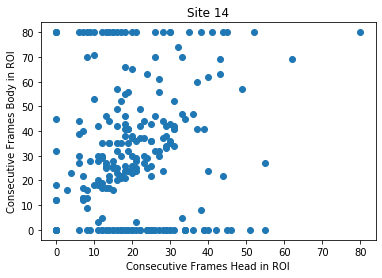

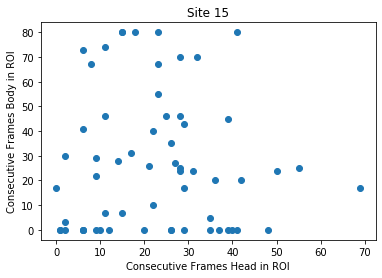

In [6]:
# Plot Scatter of ROI occupancy for each Site
for site in range(16):
    plt.scatter(all_head_in_roi[site], all_body_in_roi[site])
    plt.xlabel("Consecutive Frames Head in ROI")
    plt.ylabel("Consecutive Frames Body in ROI")
    plt.title(f"Site {site}")
    plt.show()

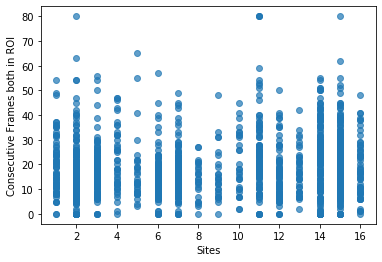

In [50]:
plt.scatter(
    all_both_in_roi_sites, all_both_in_roi,
    alpha=0.7
    )
plt.xlabel("Sites")
plt.ylabel("Consecutive Frames both in ROI")
plt.show()

In [57]:
both_thresholds = [5, 2, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 2, 5, 5]
for site in np.arange(16)+1:
    site_vals = all_both_in_roi[all_both_in_roi_sites==site]
    ratio = np.sum(site_vals < both_thresholds[site-1])/site_vals.size
    print(ratio)

0.028169014084507043
0.09444444444444444
0.03225806451612903
0.044444444444444446
0.06060606060606061
0.07142857142857142
0.0673076923076923
0.041666666666666664
0.038461538461538464
0.06896551724137931
0.057692307692307696
0.05555555555555555
0.02564102564102564
0.1043956043956044
0.05508474576271186
0.08196721311475409


In [56]:
# Define occupancy thresholds for each site (see scatterplot)
thresholds = [
    15, 10, 10, 15, 10, 10, 10, 15, 15, 15, 15, 10, 15, 10, 10, 10
    ]

## Plot number of excluded/included navigation hops

In [58]:
# Collect Head/Body in ROI values
empty_nav_included = []
empty_nav_excluded = []
full_nav_included = []
full_nav_excluded = []
for key in h5_path_dict.keys():
    if "RBY" in key: continue
    for fil in range(len(h5_path_dict[key])):
        fil_string = h5_path_dict[key][fil].as_posix()
        f = h5py.File(fil_string, 'r')
        exp_data = ExpData(f)
        _, _, _, noncrch_hops = exp_data.get_crch_hops()
        for hop_idx in noncrch_hops:
            hop = exp_data.hops[hop_idx]
            hop_site = exp_data.hop_end_wedges[hop_idx]
            if hop_site == 17: continue
            hop_start = hop - 20*2
            hop_end = hop + 20*2
            is_full = exp_data.cache_present[hop_idx, hop_site-1]
            if hop_start < 0 or hop_end >= exp_data.num_frames:
                continue
            head_in_roi = in_ellipse(
                exp_data.x_head[hop_start:hop_end],
                exp_data.y_head[hop_start:hop_end],
                head_centers[hop_site - 1], head_semiaxes[hop_site - 1]
                )
            body_in_roi = in_ellipse(
                exp_data.x[hop_start:hop_end],
                exp_data.y[hop_start:hop_end],
                body_centers[hop_site - 1], body_semiaxes[hop_site - 1]
                )
            both_in_roi = np.logical_and(head_in_roi, body_in_roi)
            head_exceeds_thresh = get_max_consecutive(head_in_roi) > thresholds[hop_site - 1]
            body_exceeds_thresh = get_max_consecutive(body_in_roi) > thresholds[hop_site - 1]
            both_exceeds_thresh = get_max_consecutive(both_in_roi) > both_thresholds[hop_site - 1]
            is_excluded = both_exceeds_thresh
            if is_full and is_excluded:
                full_nav_excluded.append(hop_site)
            elif is_full and not is_excluded:
                full_nav_included.append(hop_site)
            elif not is_full and is_excluded:
                empty_nav_excluded.append(hop_site)
            elif not is_full and not is_excluded:
                empty_nav_included.append(hop_site)

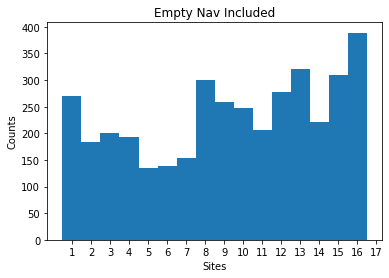

In [59]:
# Plot 1
plt.hist(empty_nav_included, bins=np.arange(17)+0.5)
plt.title("Empty Nav Included")
plt.ylabel("Counts")
plt.xlabel("Sites")
plt.xticks(np.arange(17)+1, np.arange(17)+1)
plt.show()

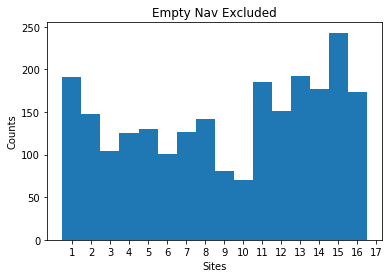

In [60]:
# Plot 2
plt.hist(empty_nav_excluded, bins=np.arange(17)+0.5)
plt.title("Empty Nav Excluded")
plt.ylabel("Counts")
plt.xlabel("Sites")
plt.xticks(np.arange(17)+1, np.arange(17)+1)
plt.show()

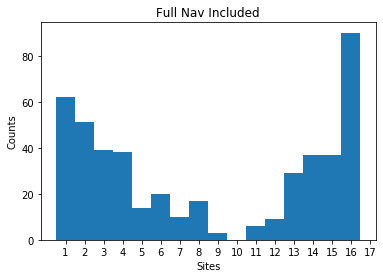

In [61]:
# Plot 3
plt.hist(full_nav_included, bins=np.arange(17)+0.5)
plt.title("Full Nav Included")
plt.ylabel("Counts")
plt.xlabel("Sites")
plt.xticks(np.arange(17)+1, np.arange(17)+1)
plt.show()

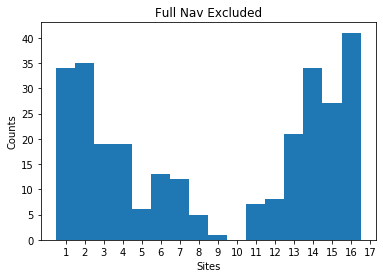

In [62]:
# Plot 4
plt.hist(full_nav_excluded, bins=np.arange(17)+0.5)
plt.title("Full Nav Excluded")
plt.ylabel("Counts")
plt.xlabel("Sites")
plt.xticks(np.arange(17)+1, np.arange(17)+1)
plt.show()